In [1]:
import pandas as pd
from bokeh.io import output_notebook
from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource, HoverTool, NumeralTickFormatter, Label
from bokeh.palettes import Category10
import matplotlib.pyplot as plt

<h2>Making mass spectra interactive with bokeh</h2>

Visualizing peptide fragmentation mass spectra

Import an example of a fragment ion spectrum:<br>
a spectrum is a list of value pairs: mass-to-charge (shortened <i>m/z</i>) and inetsity of a signal for each ion

In [2]:
df = pd.read_csv('tmt_spectrum_example.csv', sep=',')
print(df.shape)
df.head(3)

(477, 2)


,mz,Intensity
0,101.07090,3075.85
1,102.05305,650.02
2,102.05502,7881.04


Assign a precursor <i>m/z</i> and charge, they are often known and stored alongside the information about fragment ions

In [3]:
precMZ = 939.88733
precCh = 5

<h3>Take a look at a static view of the spectrum using matplotlib</h3>

Matplotlib plots are highly customizable, which makes it the choice for preparing a publication quality spectra. The <i>stem</i> method is handy for displaying mass spectra:

Text(0, 0.5, 'Intensity')

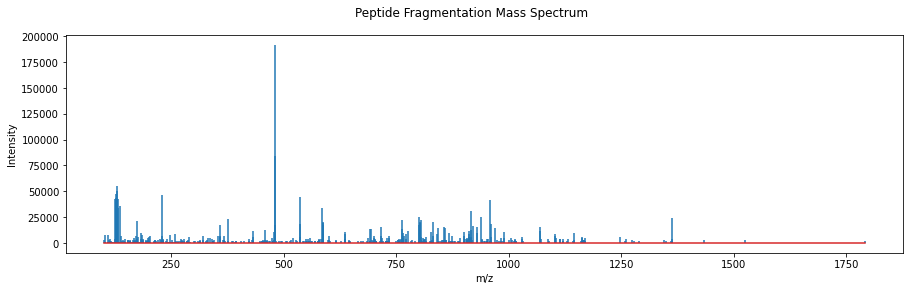

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(15,4))
fig.suptitle('Peptide Fragmentation Mass Spectrum')

ax.stem( df['mz'], df['Intensity'], markerfmt=' ' )
ax.set_xlabel('m/z')
ax.set_ylabel('Intensity')

As you can see, the typical characteristics of a tandem mass spectrum are:
* High density of the <i>m/z</i> values, a spectrum has dozens or even hundreds of points
* Substantial differences in the intensity (height) of the signals

It is impossible to put all <i>m/z</i> labels onto the plot, but it is of primary interest for the scientists to see those values. An interactive highlighting of <i>m/z</i> would come very handy!

<h3>Render bokeh plot</h3>

In [5]:
mainTitle = 'Peptide Fragmentation Mass Spectrum'
cds = ColumnDataSource(data=df)

In [6]:
output_notebook()

Loading BokehJS ...

In [7]:
#output_file('msms_tmt_bar.html')

def create_p(width=800, height=300):
    tooltips = [
        ('m/z','@mz{0.0000}'),
        ('Int','@Intensity')
        ]
    p = figure(
        plot_width=width, plot_height=height,
        title = mainTitle,
        tools = 'xwheel_zoom,xpan,box_zoom,undo,reset',
        tooltips=tooltips
        )
    return p
p = create_p()

p.vbar(
    x = 'mz', top = 'Intensity',
    source = cds,
    color = '#324ea8',# alpha = 0.8,
    width = 0.001
    )

show(p)

But there's a problem with the bar plots: they have constant width. If we set the width to a meaningful value that is based on the actual uncertainty of the <i>m/z</i> measurement, it will be extremely narrow. And the hover tool does not work as we would want it to do! 

In [8]:
p = figure(
    plot_width=800, plot_height=300,
    title = mainTitle
    )

p.line(
    x = 'mz', y = 'Intensity',
    source = cds,
    color = '#324ea8',# alpha = 0.8,
    line_width = 2
    )

show(p)

Let's modify the line, so that it adopts the expected shape, but stays continuous

In [9]:
#Triple the points on the m/z axis
mzTransformed = [ (x, x, x) for x in df['mz'] ]
#Flatten the list of tuples for the m/z axis
mzTransformed = [ x for y in mzTransformed for x in y ]
#Create the vertical bars for each intensity value
intensTransformed = [ (0, x, 0) for x in df['Intensity'] ]
#Flatten the list of tuples for the intensity axis
intensTransformed = [ x for y in intensTransformed for x in y ]
df2 = pd.DataFrame(
    {
        'mz': mzTransformed,
        'Intensity': intensTransformed
    }
)
df2.head(7)

,mz,Intensity
0,101.07090,0.00
1,101.07090,3075.85
2,101.07090,0.00
3,102.05305,0.00
4,102.05305,650.02
5,102.05305,0.00
6,102.05502,0.00


<AxesSubplot:xlabel='mz'>

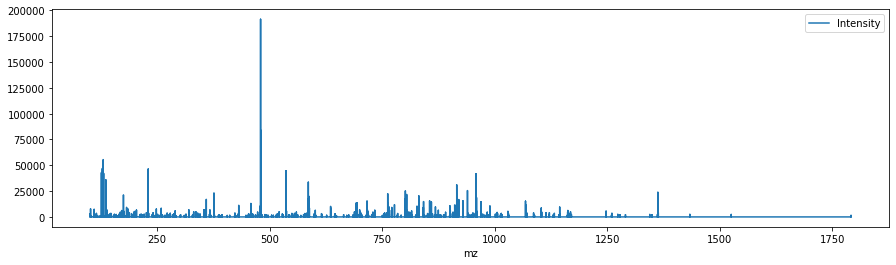

In [11]:
df2.plot(x='mz', y='Intensity', figsize=(15, 4))

In [10]:
#output_file('msms_tmt_spectrum2.html')
mainTitle = 'Peptide Fragmentation Mass Spectrum'
cds = ColumnDataSource(data=df2)

p = create_p()

maxIntens = df2['Intensity'].max()

p.line(
    'mz', 'Intensity',
    source = cds,
    color = '#324ea8',# alpha = 0.8,
    line_width = 2
    )
#Add the precursor info as a dashed line with a label
p.line(
    [precMZ, precMZ], [0, maxIntens*0.9],
    line_dash = 'dashed', line_width = 4,
    color = '#198c43', alpha = 0.5,
    )
p.add_layout(
    Label(
        x = precMZ, y = maxIntens*0.93,
        text = f'Precursor {precMZ}, {precCh}+',
        text_font_size = '10pt',
        text_color = '#198c43'
        )
    )

#Format the axis labels
p.xaxis.axis_label = 'Fragment m/z'
p.xaxis.axis_label_text_font_size = '10pt'
p.xaxis.major_label_text_font_size = '9pt'

p.yaxis.axis_label = 'Intensity'
p.yaxis.axis_label_text_font_size = '10pt'
p.yaxis.major_label_text_font_size = '9pt'
p.yaxis.formatter = NumeralTickFormatter(format='0.')

show(p)

<h3>What if the signals are not al the same?</h3>

Download the same spectrum with annotations

In [11]:
dfA = pd.read_csv('tmt_spectrum_annotated.csv', sep=',')
print(dfA.shape)
dfA.head(3)

(477, 3)


,mz,Intensity,Annotation
0,101.07090,3075.85,Unknown
1,102.05305,650.02,Unknown
2,102.05502,7881.04,Unknown


There are 3 categories of signals:

In [12]:
dfA['Annotation'].unique()

array(['Unknown', 'Identified', 'Contaminant'], dtype=object)

In [13]:
mzTransformed = [ (x, x, x) for x in dfA['mz'] ]
mzTransformed = [ x for y in mzTransformed for x in y ]
intensTransformed = [ (0, x, 0) for x in dfA['Intensity'] ]
intensTransformed = [ x for y in intensTransformed for x in y ]
annotTransformed = [ (x, x, x) for x in dfA['Annotation'] ]
annotTransformed = [ x for y in annotTransformed for x in y ]
dfA2 = pd.DataFrame(
    {
        'mz': mzTransformed,
        'Intensity': intensTransformed,
        'Annotation': annotTransformed
    }
)
dfA2.head(7)

,mz,Intensity,Annotation
0,101.07090,0.00,Unknown
1,101.07090,3075.85,Unknown
2,101.07090,0.00,Unknown
3,102.05305,0.00,Unknown
4,102.05305,650.02,Unknown
5,102.05305,0.00,Unknown
6,102.05502,0.00,Unknown


In [14]:
#output_file('msms_tmt_spectrum_Cat.html')
mainTitle = 'Peptide Fragmentation Mass Spectrum'
#Number of categories
ncat = len( dfA['Annotation'].unique() )
#Create a separate ColumnDataSource for each categorical value
sources = []

for idx, cat in enumerate( dfA2['Annotation'].unique() ):
    sources.append(
        (
            idx, cat,
            ColumnDataSource(
                data=dfA2[
                    dfA2['Annotation'] == cat
                ]
            )
        )
    )
print(sources)

p = create_p()

maxIntens = df2['Intensity'].max()

for idxColor, cat, cds in sources:
    #If there are more than 10 categories, the colors will start to rotate
    idxColor = idxColor % 10
    p.line(
        'mz', 'Intensity',
        source = cds,
        color = Category10[10][idxColor],
        line_width = 2, alpha = 0.7,
        legend_label=cat
    )
#Add the baseline to make the look cleaner 
p.line(
    x = [ dfA2['mz'].min(), dfA2['mz'].max() ],
    y = [0, 0],
    color = Category10[10][0],
    line_width = 3
)
p.legend.location = 'top_right'
p.legend.click_policy = 'hide'
p.legend.title = 'Signal Type'
#Add the precursor info as a dashed line with a label
p.line(
    [precMZ, precMZ], [0, maxIntens*0.9],
    line_dash = 'dashed', line_width = 4,
    color = '#a31534', alpha = 0.5,
    )
p.add_layout(
    Label(
        x = precMZ, y = maxIntens*0.93,
        text = f'Precursor {precMZ}, {precCh}+',
        text_font_size = '10pt',
        text_color = '#a31534'
        )
    )

#Format the axis labels
p.xaxis.axis_label = 'Fragment m/z'
p.xaxis.axis_label_text_font_size = '10pt'
p.xaxis.major_label_text_font_size = '9pt'

p.yaxis.axis_label = 'Intensity'
p.yaxis.axis_label_text_font_size = '10pt'
p.yaxis.major_label_text_font_size = '9pt'
p.yaxis.formatter = NumeralTickFormatter(format='0.')

show(p)

[(0, 'Unknown', ColumnDataSource(id='1343', ...)), (1, 'Identified', ColumnDataSource(id='1344', ...)), (2, 'Contaminant', ColumnDataSource(id='1345', ...))]
